In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
!pip install Livelossplot
from livelossplot import PlotLossesKeras

from glob import glob
import os
import shutil

import numpy as np
import pandas as pd
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# AIM
## To classify the images into 
### IDC+
### IDC-

# Validation Strategy:

## Train Data Size= 0.7*Total_Data
## Validation Data Size= 0.21* Total_Data
## Test Data Size= 0.09 * Total_Data

# Augmentaions Used:
## Each Image is rotated through 45 angles


In [2]:

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb

print("All modules have been imported")

All modules have been imported


In [3]:
sampling_seed = 0
size_4_training0 = 78786
size_4_training1 = 78786
img_size = 50
training_reshape=(-1, img_size, img_size, 3)
epoch_4_test = 15

In [4]:
import os
os.makedirs('../working/data/train_seg/idc-minus/')     
os.makedirs('../working/data/train_seg/idc-plus/')  
os.makedirs('../working/data/test_seg/idc-minus/')     
os.makedirs('../working/data/test_seg/idc-plus/')  
os.makedirs('../working/data/val_seg/idc-minus/')     
os.makedirs('../working/data/val_seg/idc-plus/') 

In [5]:

import random
from glob import glob
imagePatches = glob('../input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
train_dir='../working/data/train_seg/'
validation_dir='../working/data/val_seg/'
test_dir = '../working/data/test_seg/'  

class0 = [] # 0 = idc+
class1 = [] # 1 = idc-
imagePatches = glob('../input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    elif filename.endswith("class1.png"):
         class1.append(filename)

print(class0[0:10])

#sampling 10000 images from class 0 and class 1 to train the model

['../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x451_y901_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x801_y451_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x151_y1051_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y901_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x701_y651_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x951_y1401_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/102

In [6]:
random.seed(sampling_seed)
class0sample=random.sample(class0,size_4_training0)
class0label=np.zeros(size_4_training0)
class1sample=random.sample(class1,size_4_training1)
class1label=np.ones(size_4_training1)

class0sample_train, class0sample_test1, class0label_train, class0label_test1 = train_test_split(class0sample, class0label, test_size=0.3, random_state=42)
class0sample_val, class0sample_test,  class0label_val, class0label_test = train_test_split(class0sample_test1, class0label_test1, test_size=0.3, random_state=42)
print(len(class0sample_train))
print(len(class0sample_test))
print(len(class0sample_val))
class1sample_train, class1sample_test1, class1label_train, class1label_test1 = train_test_split(class1sample, class1label, test_size=0.3, random_state=42)
class1sample_val, class1sample_test, class1label_val, class1label_test = train_test_split(class1sample_test1, class1label_test1, test_size=0.3, random_state=42)
print(len(class1sample_train))
print(len(class1sample_test))
print(len(class1sample_val))

def read_and_save_data(path, file_name_array):
    for i in file_name_array:
        if i.endswith('.png'):
            head, tail = os.path.split(i)
            outputname=str(path+tail)
            shutil.copy(i, outputname)
    
class0train_path='../working/data/train_seg/idc-minus/'
class1train_path='../working/data/train_seg/idc-plus/'
class0test_path='../working/data/test_seg/idc-minus/'
class1test_path='../working/data/test_seg/idc-plus/'
class0val_path='../working/data/val_seg/idc-minus/'
class1val_path='../working/data/val_seg/idc-plus/'

read_and_save_data(class0train_path,class0sample_train)
read_and_save_data(class1train_path,class1sample_train)


read_and_save_data(class0test_path,class0sample_test)
read_and_save_data(class1test_path,class1sample_test)


read_and_save_data(class0val_path,class0sample_val)
read_and_save_data(class1val_path,class1sample_val)

55150
7091
16545
55150
7091
16545


In [7]:
import os #Operating System
import sys #System
import cv2
def readImage(path, tag):
    j=0
    image_data = []
    label=[]
    for i in os.listdir(path):
        imgname=path+i
        img = cv2.imread(imgname, cv2.IMREAD_COLOR)
        img_resized = cv2.resize(img, (img_size,img_size), interpolation=cv2.INTER_LINEAR)
        image_data.append(img_resized)
        label.append(tag)
        
    return image_data, label

import numpy as np
from tensorflow.keras.utils import *
from sklearn.utils import shuffle

class0_train, train0_label = readImage(class0train_path, 0)
class1_train, train1_label  = readImage(class1train_path, 1)
class0_test, test0_label = readImage(class0test_path, 0)
class1_test, test1_label = readImage(class1test_path, 1)
class0_val, val0_label = readImage(class0val_path, 0)
class1_val, val1_label = readImage(class1val_path, 1)

def Image_array_process(class0array,label0, class1array, label1):
    class0_array=np.array(class0array)
    class1_array=np.array(class1array)
    combined_data = np.concatenate((class0_array, class1_array))
    combined_label= np.concatenate((label0,label1), axis=0)
    assert len(combined_data) == len(combined_label)
    combined_data, combined_label = shuffle(combined_data, combined_label, random_state=0)
    # print(combined_data.shape)
    length=len(combined_data)
    combined_label=to_categorical(combined_label,num_classes=2)
    
    return combined_data, combined_label


X_train, y_train=Image_array_process(class0_train, train0_label, class1_train, train1_label)
X_test, y_test=Image_array_process(class0_test, test0_label, class1_test, test1_label)
X_val, y_val=Image_array_process(class0_val, val0_label, class1_val, val1_label)

In [8]:
print(len(class0_train))
print(len(class1_train))
print(len(class0_test))
print(len(class1_test))
print(len(class0_val))
print(len(class1_val))

55150
55150
7091
7091
16545
16545


# Data generator

In [9]:
train_data=X_train
train_label=y_train

test_data=X_test
test_label=y_test

val_data=X_val
val_label=y_val

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.callbacks import *


#train_datagen2 = ImageDataGenerator(rescale = 1/255)

train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                  #width_shift_range = 0.1,
                                  #height_shift_range = 0.1,
                                  #fill_mode = 'constant',
                                  #zoom_range = 0.1,
                                  #rotation_range = 20
                                  )

val_datagen = ImageDataGenerator(rescale = 1.0/255)
val2_datagen = ImageDataGenerator(rescale = 1.0/255)

train_generator = train_datagen.flow(train_data,
                                     train_label, 
                                     #batch_size = 16, 
                                     #shuffle = False
                                    )

val_generator = val_datagen.flow(test_data,
                                 test_label,
                                 #batch_size = 16,
                                 #shuffle = False
                                )
val2_generator = val_datagen.flow(val_data,
                                 val_label,
                                 #batch_size = 16,
                                 #shuffle = False
                                 )

# Model configure

In [11]:
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'sigmoid'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 30
EARLY_STOP_PATIENCE = 10
#resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

from tensorflow.keras.applications import DenseNet169
base_model = DenseNet169(
    #weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    weights='imagenet',
    include_top=False,
    input_shape=(img_size,img_size,3)
    )
#from tensorflow.keras.applications.mobilenet import MobileNet
base_model.trainable = False
model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(4096,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.summary()


2022-06-05 00:39:50.768986: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


51888128/51877672 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 1, 1, 1664)        12642880  
_________________________________________________________________
flatten (Flatten)            (None, 1664)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1664)              6656      
_________________________________________________________________
dense (Dense)                (None, 4096)              6819840   
_________________________________________________________________
batch_normalization_1 (Batch (None, 4096)              16384     
_________________________________________________________________
activation (Activation)      (None, 4096)              0         
_________________________________________________________

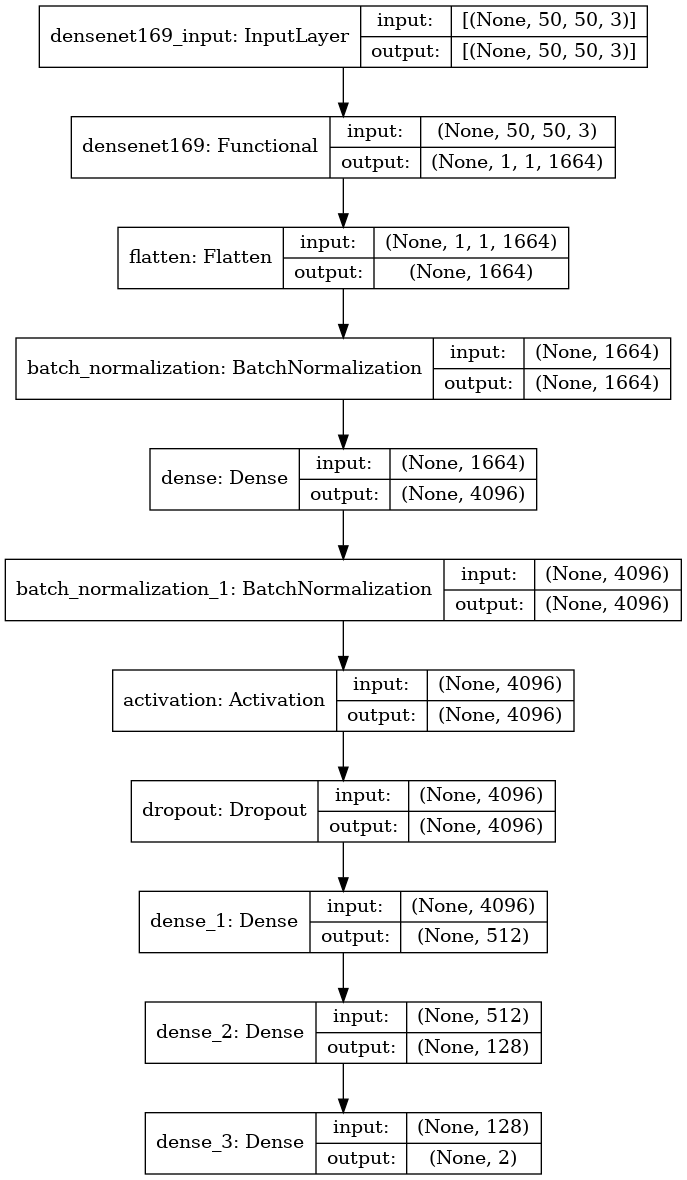

In [12]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='convnet.png') 

In [13]:
# os.makedirs('../working/log/')
MODEL_INIT = '../working/init_model.h5'
MODEL_PATH = '../working/test_model.h5'

In [14]:
callbacks1 = [EarlyStopping(monitor='val_accuracy', patience=8, verbose=1), ModelCheckpoint(MODEL_INIT, monitor='val_accuracy', save_best_only=True)]
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [15]:
%time
#history1=model.fit(X_train, y_train,validation_data=(X_test, y_test),verbose = 1,epochs = 100, callbacks=callbacks1)
history1=model.fit_generator(train_generator,validation_data=val_generator,verbose = 1,epochs = epoch_4_test,callbacks=callbacks1)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 8.82 µs


2022-06-05 00:39:59.768592: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
3447/3447 [==============================] - 849s 243ms/step - loss: 0.4375 - accuracy: 0.8044 - val_loss: 0.4153 - val_accuracy: 0.8155
Epoch 2/15
3447/3447 [==============================] - 830s 241ms/step - loss: 0.4070 - accuracy: 0.8203 - val_loss: 0.4024 - val_accuracy: 0.8220
Epoch 3/15
3447/3447 [==============================] - 837s 243ms/step - loss: 0.3926 - accuracy: 0.8262 - val_loss: 0.3978 - val_accuracy: 0.8278
Epoch 4/15
3447/3447 [==============================] - 852s 247ms/step - loss: 0.3793 - accuracy: 0.8323 - val_loss: 0.4004 - val_accuracy: 0.8288
Epoch 5/15
3447/3447 [==============================] - 846s 245ms/step - loss: 0.3650 - accuracy: 0.8400 - val_loss: 0.4015 - val_accuracy: 0.8290
Epoch 6/15
3447/3447 [==============================] - 847s 246ms/step - loss: 0.3480 - accuracy: 0.8471 - val_loss: 0.4007 - val_accuracy: 0.8286
Epoch 7/15
3447/3447 [==============================] - 849s 246ms/step - loss: 0.3284 - accuracy: 0.8560 - val_

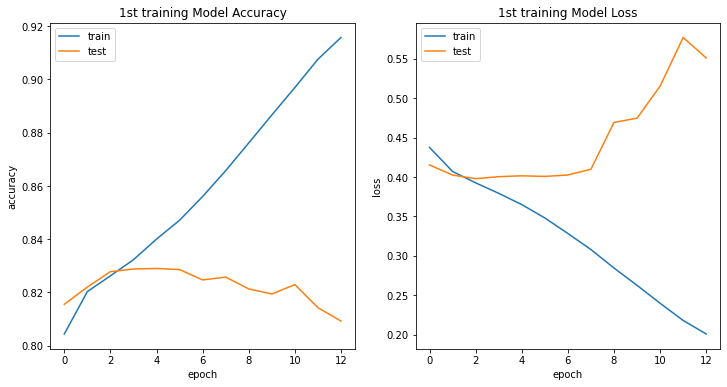

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (12, 6))
plt.subplot(121)
#plotting the Accuracy of test and training sets
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('1st training Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(122)
#plotting the loss of test and training sets
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('1st training Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

analyse of 1st model
VAL kappa
0.6497431248111212
analyse 1st model
report of val data
              precision    recall  f1-score   support

           0       0.81      0.84      0.83     16545
           1       0.84      0.81      0.82     16545

    accuracy                           0.82     33090
   macro avg       0.83      0.82      0.82     33090
weighted avg       0.83      0.82      0.82     33090



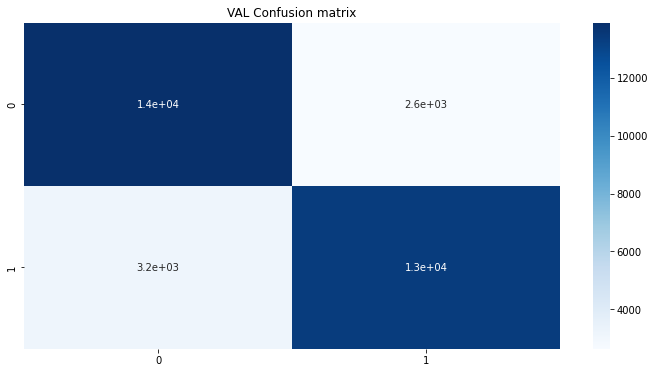

In [17]:
import sklearn
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix
#---------------
from keras.models import load_model

model1 = load_model(MODEL_INIT, compile=False)
print("analyse of 1st model")


cf_matrix_val = confusion_matrix(
    np.concatenate([np.argmax(val2_generator[i][1], axis=1) for i in range(len(val2_generator))]),    
    np.argmax(model1.predict_generator(val2_generator, steps=len(val2_generator)), axis=1) 
)

plt.figure(figsize = (12, 6))
sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
plt.title("VAL Confusion matrix")
# kappa VAL
kappa_val = cohen_kappa_score(
    np.concatenate([np.argmax(val2_generator[i][1], axis=1) for i in range(len(val2_generator))]),    
    np.argmax(model1.predict_generator(val2_generator, steps=len(val2_generator)), axis=1) 
)
print("VAL kappa")
print(kappa_val)



print("analyse 1st model")
print("report of val data")
report = sklearn.metrics.classification_report(
    np.concatenate([np.argmax(val2_generator[i][1], axis=1) for i in range(len(val2_generator))]),    
    np.argmax(model1.predict_generator(val2_generator, steps=len(val2_generator)), axis=1) 
)
print(report)

report of test data
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      7091
           1       0.84      0.82      0.83      7091

    accuracy                           0.83     14182
   macro avg       0.83      0.83      0.83     14182
weighted avg       0.83      0.83      0.83     14182

TEST kappa
0.6580172049076294


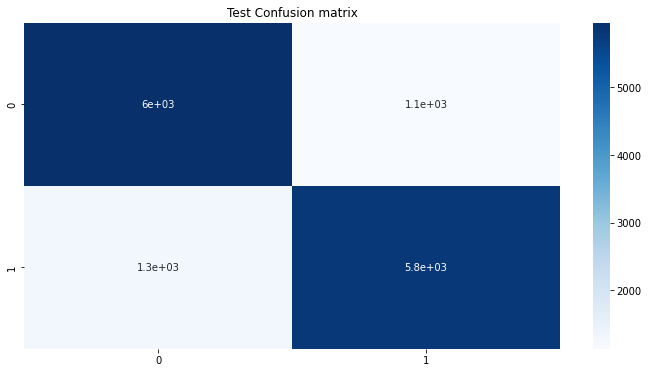

In [18]:
#------------------
cf_matrix_test = confusion_matrix(
    np.concatenate([np.argmax(val_generator[i][1], axis=1) for i in range(len(val_generator))]),    
    np.argmax(model1.predict_generator(val_generator, steps=len(val_generator)), axis=1) 
)

plt.figure(figsize = (12, 6))
sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
plt.title("Test Confusion matrix")



print("report of test data")
import sklearn

report = sklearn.metrics.classification_report(
    np.concatenate([np.argmax(val_generator[i][1], axis=1) for i in range(len(val_generator))]),    
    np.argmax(model1.predict_generator(val_generator, steps=len(val_generator)), axis=1) 
)
print(report)


# kappa TEST
kappa_test = cohen_kappa_score(
    np.concatenate([np.argmax(val_generator[i][1], axis=1) for i in range(len(val_generator))]),    
    np.argmax(model1.predict_generator(val_generator, steps=len(val_generator)), axis=1) 
)
print("TEST kappa")
print(kappa_test)

# Second Training Fine Tune